In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
import modred as mr
import numpy.matlib as ml
import scipy.interpolate as interp
from importlib import reload
import PODutils
import PIVutils

saveFolder = './RNV45-POD'

import os
if not os.path.exists(saveFolder):
    os.makedirs(saveFolder)

In [26]:
reload(PIVutils)
X, Y, U, V, Cond, Prof = PIVutils.loadDataset('/Users/Owen/Dropbox/Data/ABL/SBL PIV data/RNV45-RI2.mat',\
                                              ['X','Y','U','V'],['Cond','Prof'])

['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


In [27]:
#Rearange data into correct shape (rows all the data for a single snapshot, columns each shapshot)
uSize = U.shape
uSize

(123, 242, 750)

In [28]:
X = X/Cond["delta"]
Y = Y/Cond["delta"]

In [29]:
U[1,1,1]

0.79468638429797611

In [6]:
V[1,1,1]

0.029383627112309647

In [7]:
#Do 2D interpolation to remove any NaNs or find locations of NaNs 
#for i in range(uSize[2]):
#    U[:,:,i] = interp.interp2d(X, Y, U[:,:,i], kind='linear')

#Find the locations of all NaNs
NanLocs = np.isnan(U)
#U[NanLocs] = 0
    

In [8]:
#Calculate mean velocity profiles
Umean = np.nanmean(np.nanmean(U,axis=2),axis = 1)
Umean
Umean.shape

Umean = np.transpose(np.tile(Umean,(uSize[2],uSize[1],1)),(2,1,0))
#Umean.shape

#Subtract mean velocity profiles from velocity fields
Uf = U - Umean;
Vf = V; #<--Mean in vertical is aprox zero
del Umean

In [9]:
#Set all NaNs to zero so that POD can run
Uf[NanLocs] = 0
Vf[NanLocs] = 0

###### Test shape of matrix needed for POD function
num_vecs = 50;  #<-- equivalent to the number of PIV snapshots (Also number of total POD modes)

vecs = np.random.random((100, num_vecs))
vecs.shape

# Old way to do POD with all data in memory

In [10]:
uAll = np.concatenate((Uf.reshape(uSize[0]*uSize[1],uSize[2]), Vf.reshape(uSize[0]*uSize[1],uSize[2])), axis = 0)
uAll.shape      

(59532, 750)

In [11]:
num_modes = 50;
modes, eig_vals, eigvecs, correlation_mat = mr.compute_POD_matrices_snaps_method(uAll, list(range(num_modes)),return_all=True)

In [12]:
print(modes.shape)
print(eig_vals.shape)

(59532, 50)
(750,)


In [13]:
correlation_mat.shape

(750, 750)

In [14]:
#Calculate the mode coefficients
C = modes.transpose()*uAll
C = np.asarray(C)

In [15]:
C.shape

(50, 750)

# Start analysis on result

In [16]:
menergy = eig_vals/np.sum(eig_vals)
menergy_sum = np.zeros(len(menergy))
for i in range(len(menergy)):
    menergy_sum[i] = np.sum(menergy[:i]);

In [17]:
reload(PODutils)
Umodes, Vmodes= PODutils.reconstructPODmodes(modes,uSize,num_modes,2)

In [18]:
modes.dtype

dtype('float64')

fig, ax = plt.subplots()
ax.bar(range(num_modes),menergy[1:num_modes]*100)

# Plot modal energy and contribution total

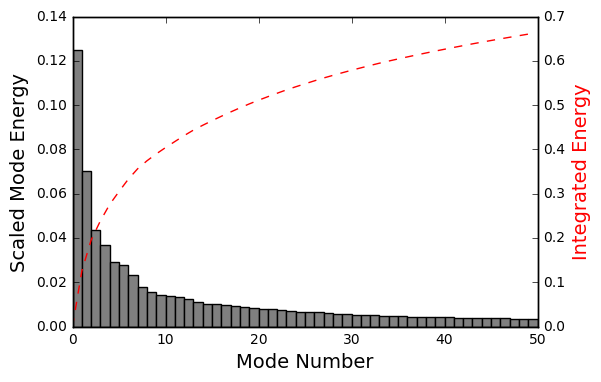

In [19]:
ind = np.arange(num_modes)  # the x locations for the groups
width = 1       # the width of the bars

f = plt.figure()
ax = plt.gca()
ax2 = plt.twinx()
rect = ax.bar(ind,menergy[:num_modes], width, color='gray')
line = ax2.plot(ind,menergy_sum[:num_modes],'--r')

ax.set_xlabel("Mode Number",fontsize=14)
ax.set_ylabel("Scaled Mode Energy",fontsize=14)
ax2.set_ylabel("Integrated Energy",fontsize=14,color='red')

f.savefig(saveFolder + '/ModeEnergy.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

# Plot some modes

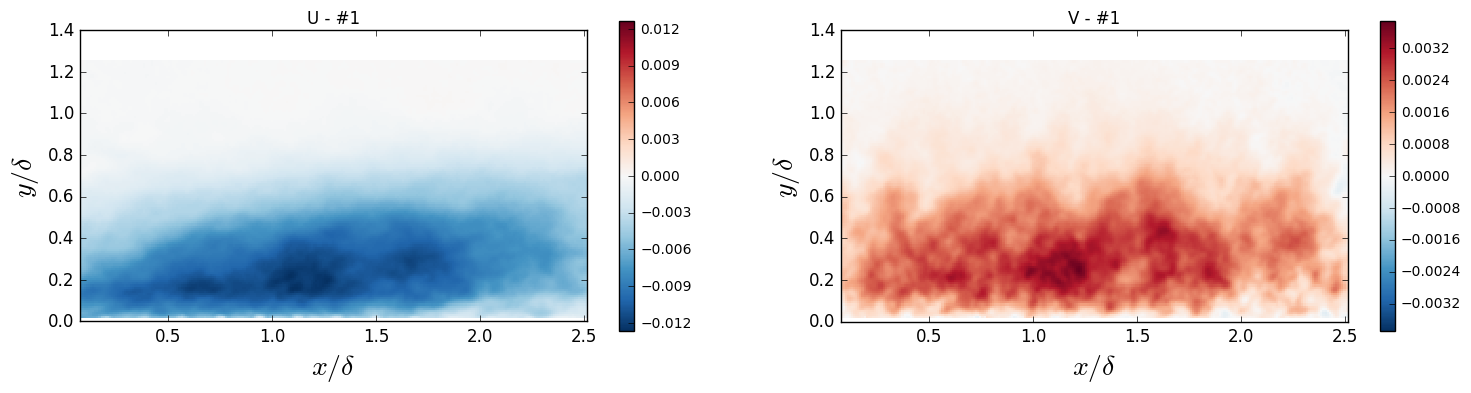

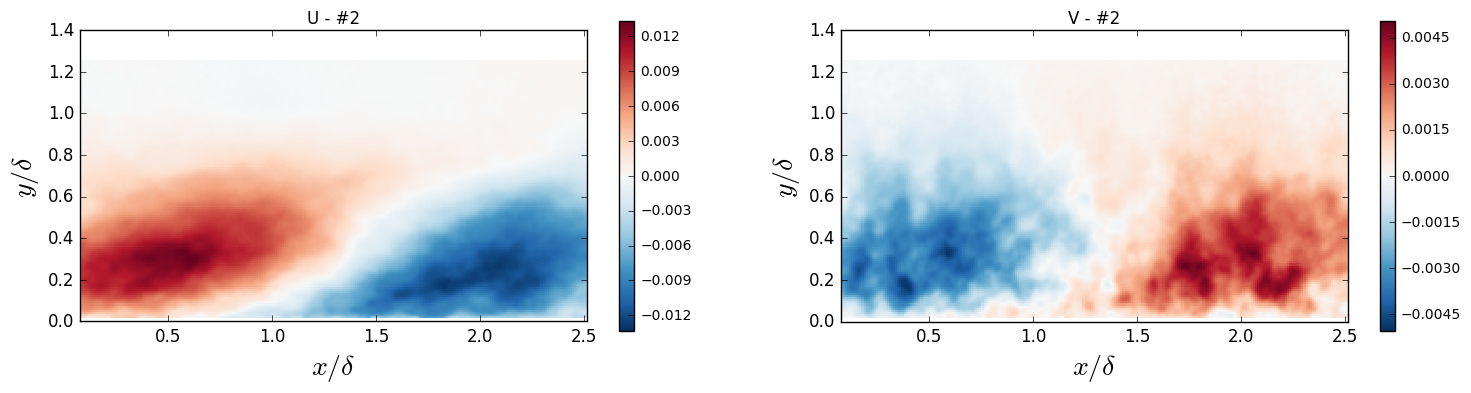

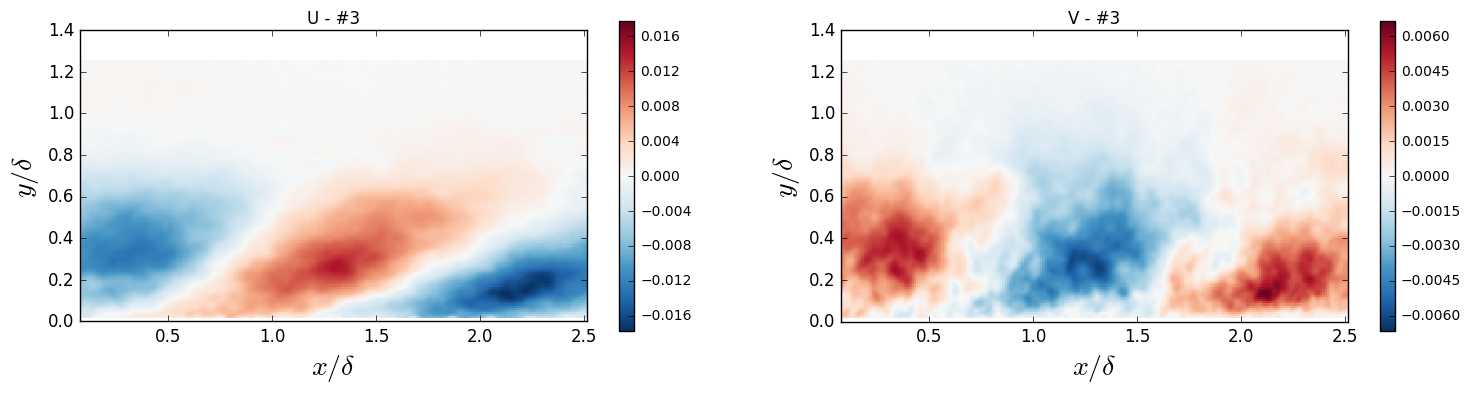

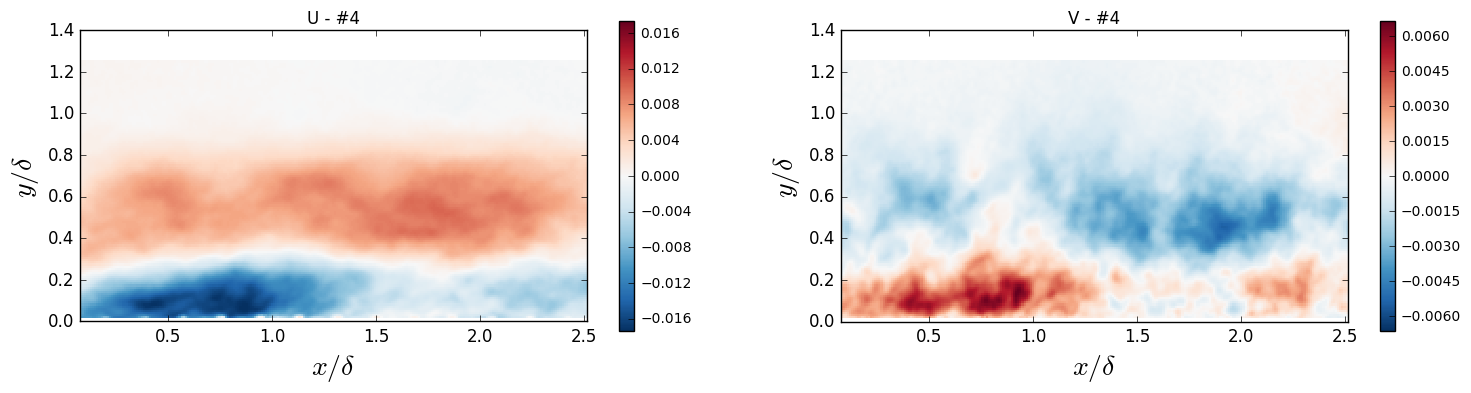

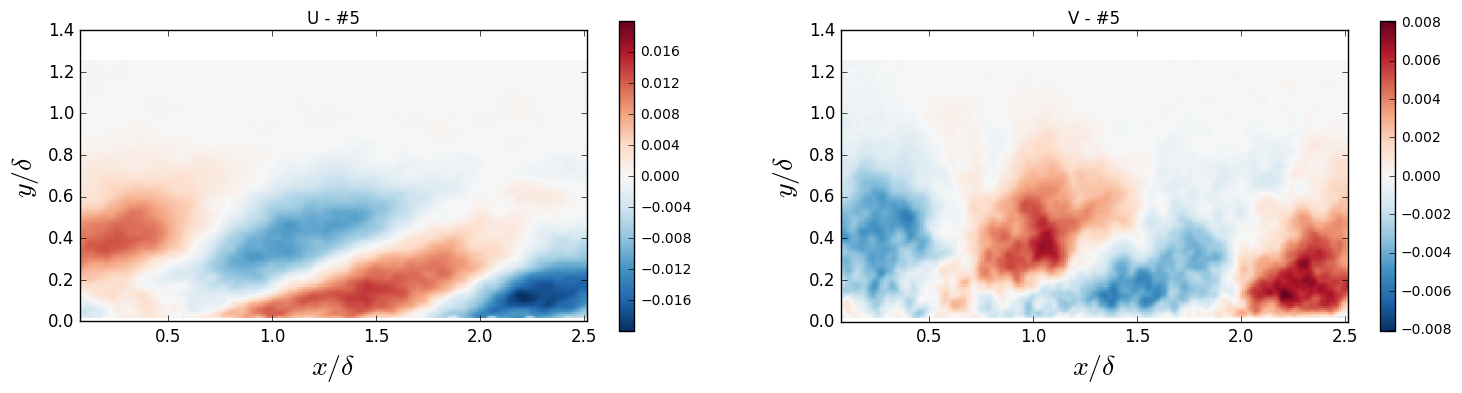

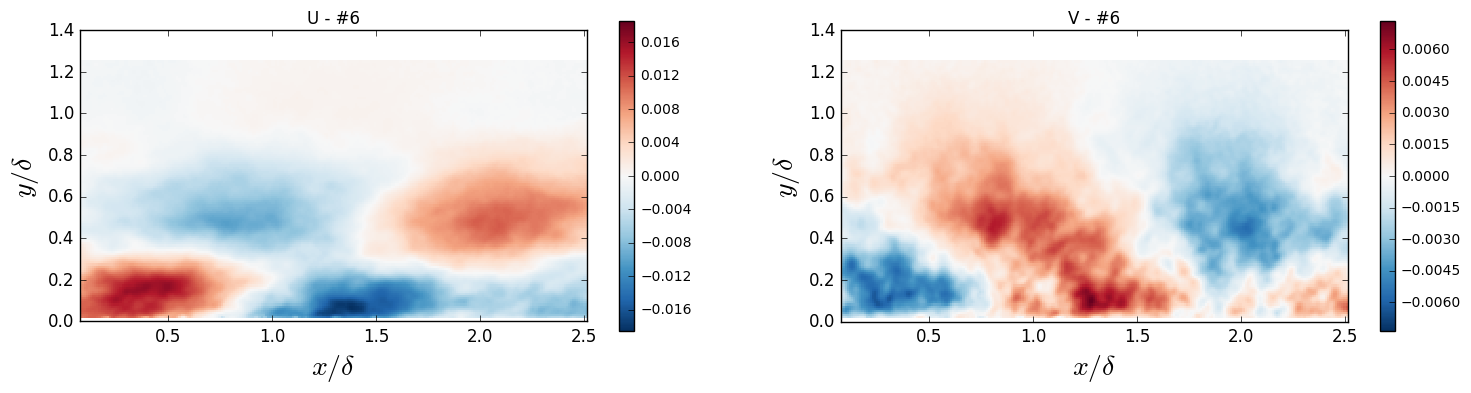

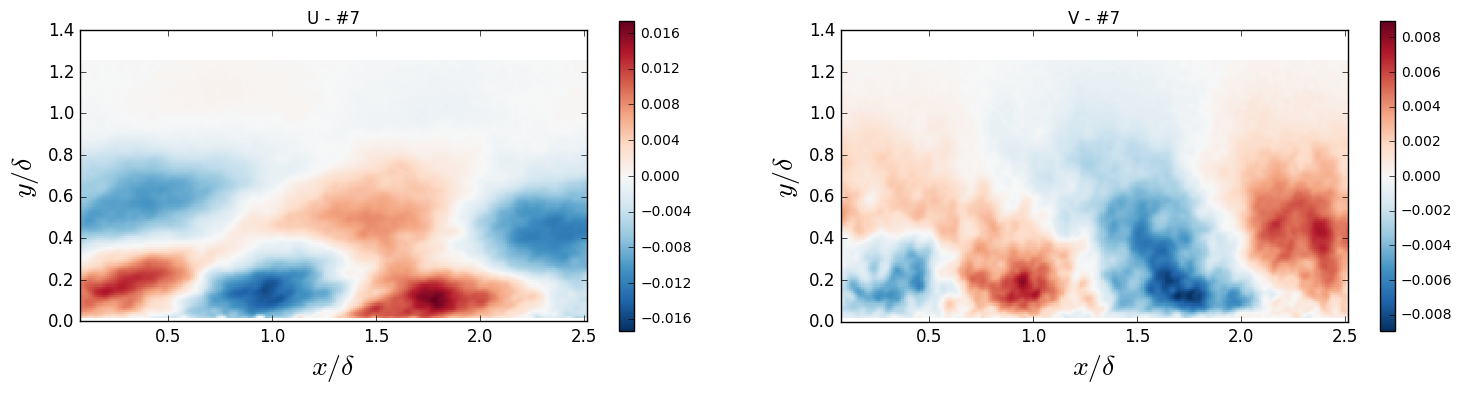

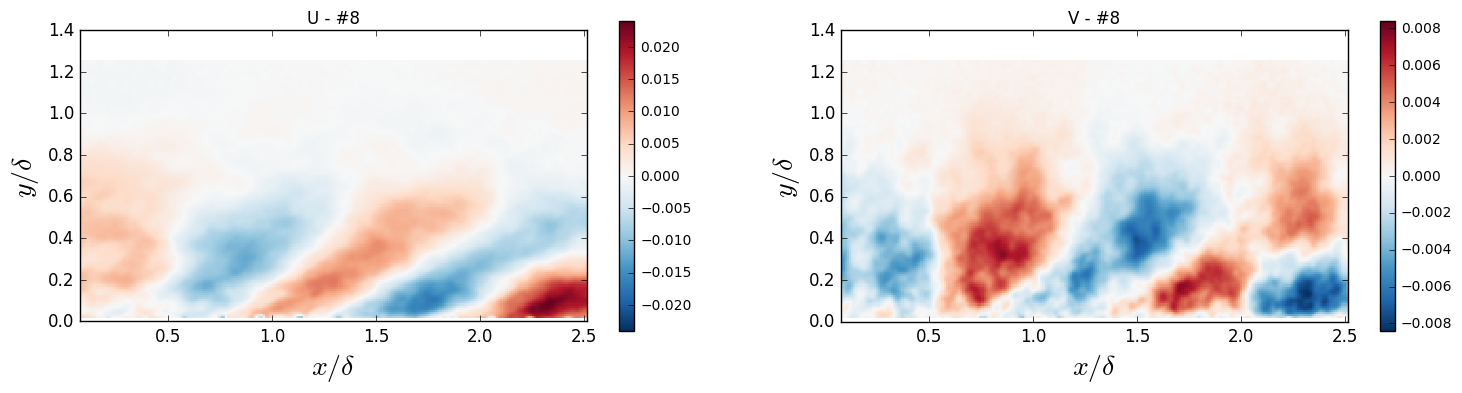

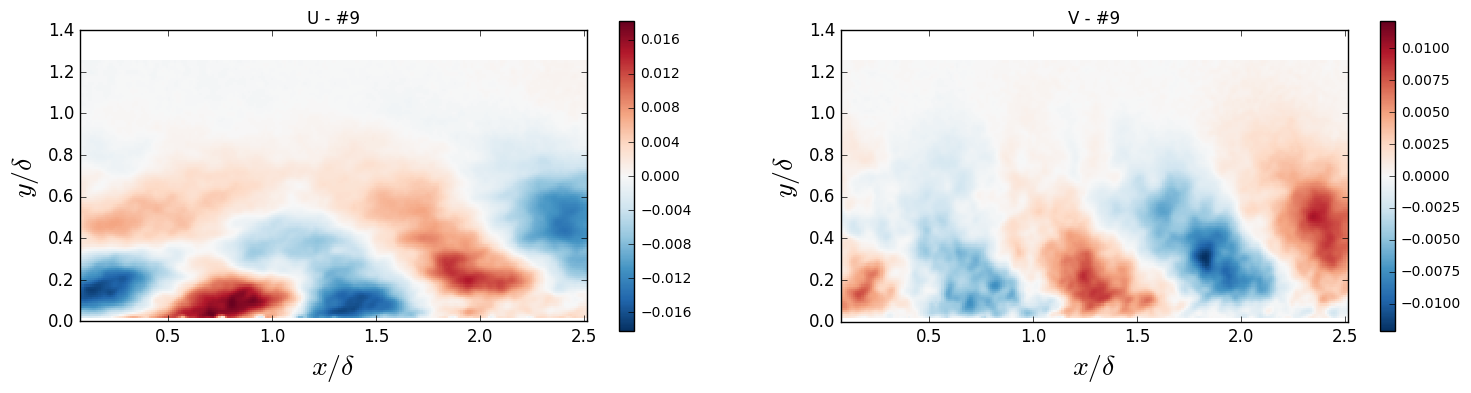

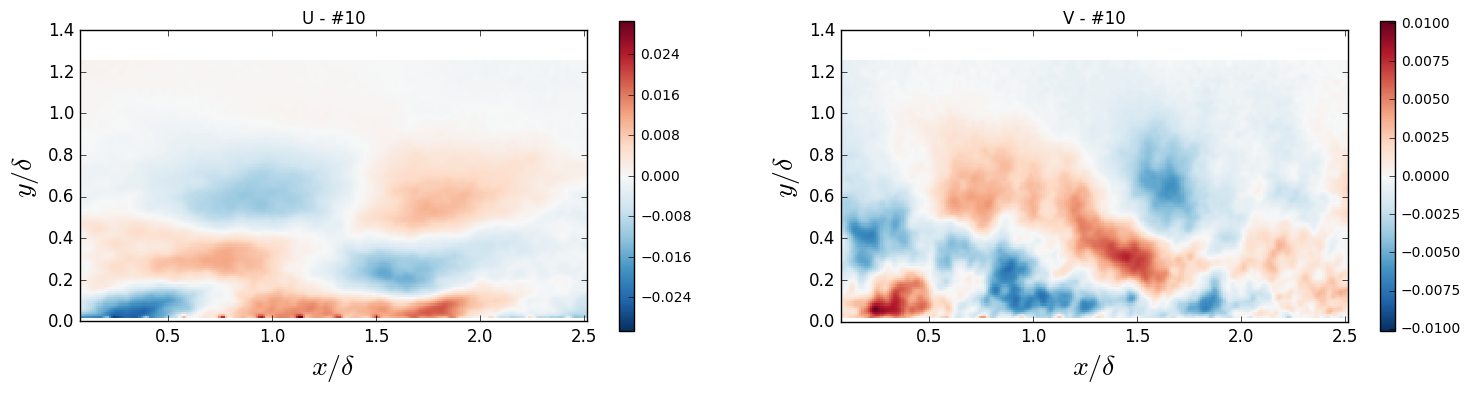

In [23]:
reload(PODutils)
PODutils.plotPODmodes2D(X,Y,Umodes,Vmodes,list(range(10)),saveFolder)

# Plot the variation of the coefficients

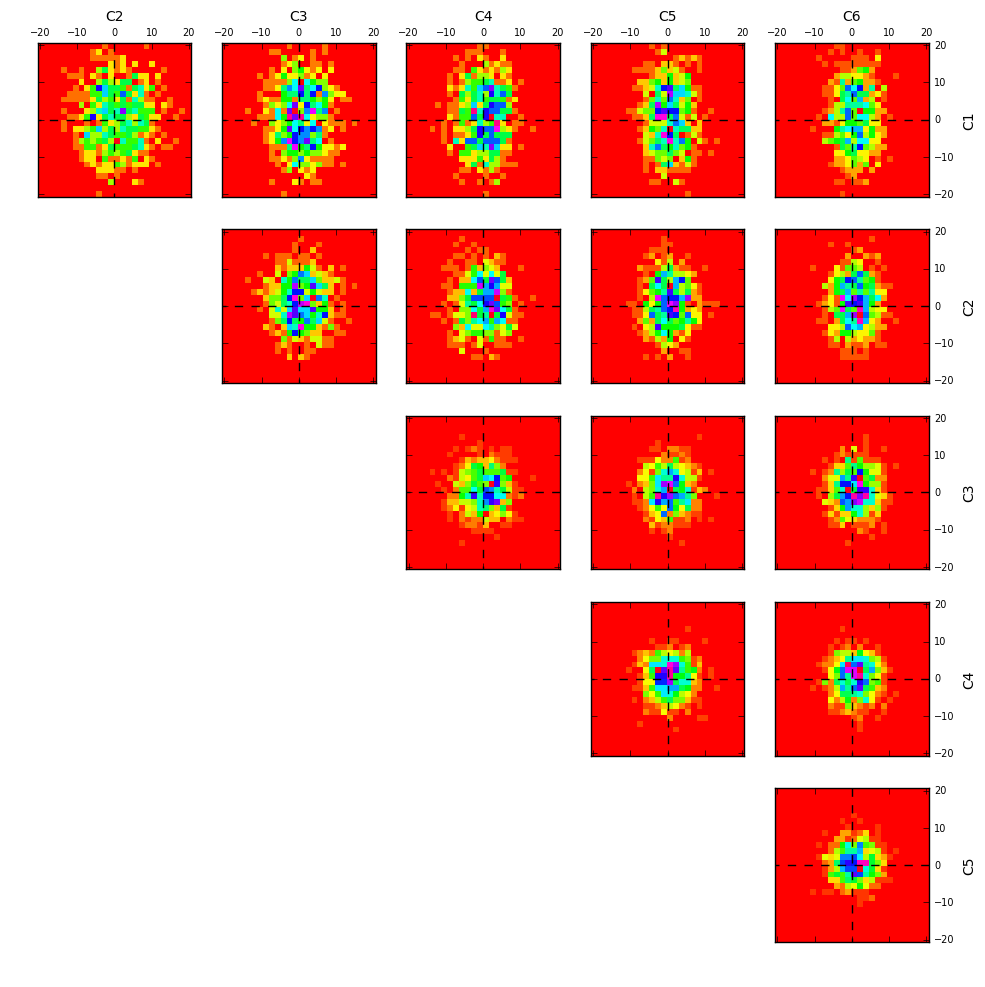

In [22]:
reload(PODutils)
PODutils.plotPODcoeff(C,list(range(6)),30,saveFolder=(saveFolder + '/Coeff.tif'))